# Data Cleaning

Here, we will clean the data that we scraped for the 2021 Boston Marathon.

## Import packages and data

Let's import the packages we will need and import the data to a pandas DataFrame. The data exists in a CSV file.

In [1]:
import pandas as pd
import numpy as np
import pycountry
import missingno as msno
import matplotlib.pyplot as plt

boston = pd.read_csv('/Users/tmcdermott/Desktop/Data Projects/marathon_splits/data/boston.csv', 
                     skipinitialspace = True)

Let's take a first look at the data in its raw form, as well as some summary information about the DataFrame.

In [2]:
boston

,place_overall,place_gender,place_division,sex,age_group,name,bib,half_split,finish_net,finish_gun
0,Place Overall,Place Gender,Place Division,M,1,NaN,BIB,HALF,Finish Net,Finish Gun
1,1,1,1,M,1,"Kipruto, Benson (KEN)",4,01:06:22,02:09:51,02:09:51
2,2,2,2,M,1,"Berhanu, Lemi (ETH)",3,01:06:23,02:10:37,02:10:37
3,3,3,3,M,1,"Yimer, Jemal (ETH)",21,01:06:21,02:10:38,02:10:38
4,4,4,4,M,1,"Ayana, Tsedat (ETH)",12,01:06:22,02:10:47,02:10:47
...,...,...,...,...,...,...,...,...,...,...
18121,NaN,NaN,NaN,W,12,"Rigney, Hansi (USA)",15935,NaN,NaN,NaN
18122,NaN,NaN,NaN,W,12,"Troisi, Cathleen (USA)",16100,NaN,NaN,NaN
18123,place_overall,place_gender,place_division,sex,age_group,name,bib,half_split,finish_net,finish_gun
18124,Place Overall,Place Gender,Place Division,W,13,NaN,BIB,HALF,Finish Net,Finish Gun


In [3]:
boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18126 entries, 0 to 18125
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   place_overall   15442 non-null  object
 1   place_gender    15436 non-null  object
 2   place_division  15436 non-null  object
 3   sex             18126 non-null  object
 4   age_group       18126 non-null  object
 5   name            18093 non-null  object
 6   bib             18125 non-null  object
 7   half_split      15612 non-null  object
 8   finish_net      15442 non-null  object
 9   finish_gun      15442 non-null  object
dtypes: object(10)
memory usage: 1.4+ MB


Immediately, we can see some issues with the data that will require cleaning, including but not limited to: 

* The scraper grabbed some header rows as it crawled through the pages.
* The data includes runners of all ages, whereas we are only interested in looking at runners age 18-39.
* There are two different finish time columns, "finish_net" and "finish_gun".
* The data type for every column is object. 
* There are rows with missing data.
* The column names could be a bit cleaner.
* First name, last name, and country are all grouped under one column. They would be more useful in separate columns.
* There aren't any columns that directly tell us the pace strategy of each runner.

We will address all of these issues and more below.

## Remove Irrelevant Data

First, let's remove the header rows that the scraper grabbed. We could subset these in various ways, but let's look for rows that have either "bib" or "BIB" in the "bib" column.

In [4]:
#Subset extraneous header rows
headers = boston[(boston['bib'] == 'BIB') | (boston['bib'] == 'bib')]

headers

,place_overall,place_gender,place_division,sex,age_group,name,bib,half_split,finish_net,finish_gun
0,Place Overall,Place Gender,Place Division,M,1,NaN,BIB,HALF,Finish Net,Finish Gun
1001,Place Overall,Place Gender,Place Division,M,1,NaN,BIB,HALF,Finish Net,Finish Gun
2002,Place Overall,Place Gender,Place Division,M,1,NaN,BIB,HALF,Finish Net,Finish Gun
2570,place_overall,place_gender,place_division,sex,age_group,name,bib,half_split,finish_net,finish_gun
2571,Place Overall,Place Gender,Place Division,M,2,NaN,BIB,HALF,Finish Net,Finish Gun
3572,Place Overall,Place Gender,Place Division,M,2,NaN,BIB,HALF,Finish Net,Finish Gun
3852,place_overall,place_gender,place_division,sex,age_group,name,bib,half_split,finish_net,finish_gun
3853,Place Overall,Place Gender,Place Division,M,9,NaN,BIB,HALF,Finish Net,Finish Gun
4854,Place Overall,Place Gender,Place Division,M,9,NaN,BIB,HALF,Finish Net,Finish Gun
5344,place_overall,place_gender,place_division,sex,age_group,name,bib,half_split,finish_net,finish_gun


These rows are clearly not actual data, so let's drop them.

In [5]:
boston.drop(headers.index, inplace = True)

Second, we are not interested in examining the influence of age on split stategy, so we will only look at data for runners age 18-39. In doing this, we are assuming that there is no variation in split strategy within this age group, which may not be true, but we will accept this a limitation of the project.

When we scraped the data, we used numbers encoded in the URL both to loop through the results pages by age group and to mark the age group in the data. The value that corresponded to runners age 18-39 was 1, so we will subset the data just for this value.

In [6]:
#Subset runners that are not age 18-39
not18_39 = boston[boston['age_group'] != '1'].index

#Drop those runners
boston.drop(not18_39, axis = 0, inplace = True)

Third, the data includes finish gun time as well as finish net time. Large marathons like Boston typically start in waves, with the fastest runners crossing the start line very close to the gun and runners further back starting much later after the gun. Gun time is the elapsed time between the starting gun and the runner crossing the finish line, while net time is the time between the runner crossing the start line and crossing the finish line. Runners usually have a tracker on their bib or shoe that measures the net time. We only need to know the net time, so let's drop the "finish_gun" column from the data. We will also drop the "age_group" column because it is no longer necessary.

In [7]:
boston.drop(['finish_gun', 'age_group'], axis = 1, inplace = True)

Finally, some runners did not have finish times, half splits, or both. Runners would most likely be missing finish times if they registered but either did not start or did not finish. Because we cannot get any meaningful insights about pace strategy from runners who did not finish, we can drop them from the data.

Missing half splits are harder to explain, but they might just be due to error. We will look at this when we look at missing data more generally a bit later.

In [8]:
#Subset the rows that are missing finish times
boston_dnf = boston[boston['finish_net'].isnull()]

#Drop rows that are missing finish times
boston.drop(boston_dnf.index, inplace = True)

#Check the results of changes so far
boston

,place_overall,place_gender,place_division,sex,name,bib,half_split,finish_net
1,1,1,1,M,"Kipruto, Benson (KEN)",4,01:06:22,02:09:51
2,2,2,2,M,"Berhanu, Lemi (ETH)",3,01:06:23,02:10:37
3,3,3,3,M,"Yimer, Jemal (ETH)",21,01:06:21,02:10:38
4,4,4,4,M,"Ayana, Tsedat (ETH)",12,01:06:22,02:10:47
5,5,5,5,M,"Barsoton, Leonard (KEN)",22,01:06:22,02:11:11
...,...,...,...,...,...,...,...,...
12235,15372,7435,2838,W,"List, Chanit (USA)",17468,03:07:46,06:58:40
12236,15376,7437,2839,W,"Marino-Babcock, Emily (USA)",18401,03:14:25,07:04:40
12237,15377,7438,2840,W,"Malloy, Meagan (USA)",17524,03:17:51,07:06:30
12238,15379,7440,2841,W,"Lee, Sherry (USA)",4112,03:21:04,07:09:48


## Fix Column Data Types

We saw earlier that almost all the columns were read as type "object". We would like the placing and bib columns to be integers and the time columns to be timedeltas. Let's cast these as the correct data types. We can fill in any missing numeric values with 0 and missing times with NaT.

In [9]:
#Create lists of numeric and time columns for each set of data
numeric_cols = ['place_overall', 'place_gender', 'place_division','bib']
time_cols = ['half_split', 'finish_net']


def convert_types(df, numeric_cols, time_cols):
    """Takes lists of columns and a DataFrame, converts columns of DataFrame to type int and timedelta."""
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1).fillna(0)
    df[numeric_cols] = df[numeric_cols].astype('int')
    df[time_cols] = df[time_cols].apply(pd.to_timedelta, unit = 's', errors = 'coerce')

convert_types(boston, numeric_cols, time_cols)

#Check data types
boston.dtypes

place_overall               int64
place_gender                int64
place_division              int64
sex                        object
name                       object
bib                         int64
half_split        timedelta64[ns]
finish_net        timedelta64[ns]
dtype: object

## Missing Data

Let's look at missing data generally. Recall that missing placing values have already been filled in with zeroes and missing finish times have been dropped from the data. 

In [10]:
def percent_missing(df):
    """Takes DataFrame, returns percentage of data missing for each column."""
    for col in df.columns:
        pct_missing = np.round((np.mean(df[col].isnull()) * 100), decimals = 2)
        print('{} - {}%'.format(col, pct_missing))

percent_missing(boston)

place_overall - 0.0%
place_gender - 0.0%
place_division - 0.0%
sex - 0.0%
name - 0.0%
bib - 0.0%
half_split - 0.26%
finish_net - 0.0%


We are only missing a small percentage of half splits. Let's visualize this missing data using missingno.

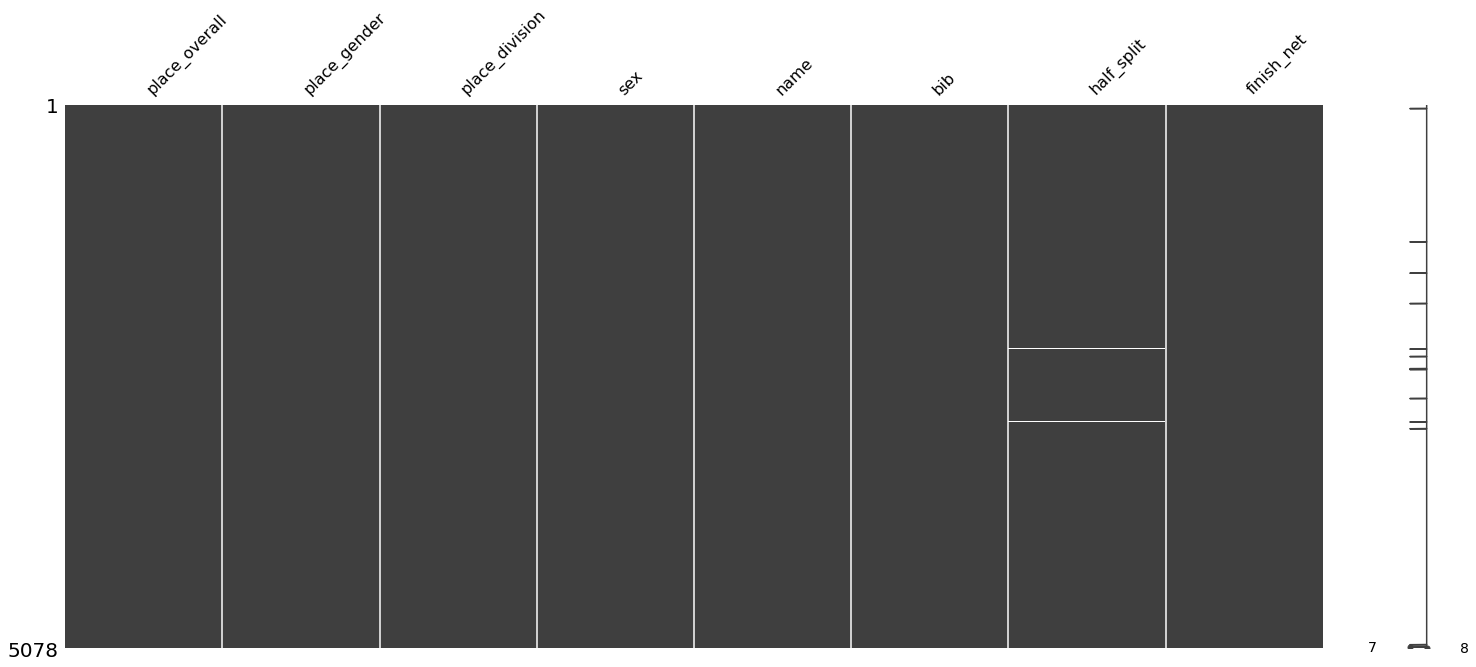

In [11]:
#Show missingness matrices for each data set
msno.matrix(boston)
plt.show()

Before we do anything about the missing data, we want to know if there is any pattern to the missing data. Data could be missing completely at random, meaning that the missingness is completely independent of the observable or missing data. Data could be missing at random, meaning there is a relationship between the missingness and the other observed data. Finally, data could be missing not at random, meaning that the value of the missing data is related to the reason it is missing.

Let's subset the rows with missing half splits and look at some descriptive statistics for those rows.

In [12]:
#Subset rows with missing half splits
missing_boston = boston[boston['half_split'].isna()]

#Print descriptive statistics for those rows
print(missing_boston.describe())

       place_overall  place_gender  place_division           bib half_split  \
count      13.000000     13.000000       13.000000     13.000000          0   
mean     4345.076923   1903.615385      789.538462   6058.153846        NaT   
std      4634.213732   2603.867845      868.290717   5919.563706        NaT   
min        -2.000000      0.000000        0.000000    296.000000        NaT   
25%      1463.000000    142.000000      120.000000   2917.000000        NaT   
50%      3194.000000    655.000000      512.000000   4115.000000        NaT   
75%      4434.000000   2611.000000     1282.000000   8403.000000        NaT   
max     15354.000000   7425.000000     2832.000000  17875.000000        NaT   

                      finish_net  
count                         13  
mean   0 days 03:45:54.846153846  
std    0 days 01:19:35.924235966  
min              0 days 02:24:36  
25%              0 days 03:06:04  
50%              0 days 03:16:09  
75%              0 days 03:45:34  
max     

Let's compare this to descriptive statistics for the data overall.

In [13]:
print(boston.describe())

       place_overall  place_gender  place_division           bib  \
count    5078.000000   5078.000000     5078.000000   5078.000000   
mean     6471.005908   3039.207365     1286.759354   9045.230996   
std      4869.943990   2470.837202      763.774328   6671.751858   
min        -2.000000      0.000000        0.000000      2.000000   
25%      2000.250000    823.500000      634.000000   2373.250000   
50%      5401.000000   2205.500000     1268.500000   8369.500000   
75%     10982.500000   5407.750000     1903.000000  16762.500000   
max     15383.000000   7941.000000     2842.000000  19651.000000   

                      half_split                 finish_net  
count                       5065                       5078  
mean   0 days 01:44:29.387166831  0 days 03:43:40.579952737  
std    0 days 00:21:52.742389997  0 days 00:52:28.962833808  
min              0 days 01:04:08            0 days 02:09:51  
25%              0 days 01:28:17            0 days 03:04:37  
50%            

There doesn't appear to be any pattern or bias to the missing data. The average runner with missing half splits tends to be only 2 minutes slower than the average runner overall, and the range of runners with missing half splits runs the gamut from very fast to very slow.

Let's also sort the data by finish time and visualize the missingness again.

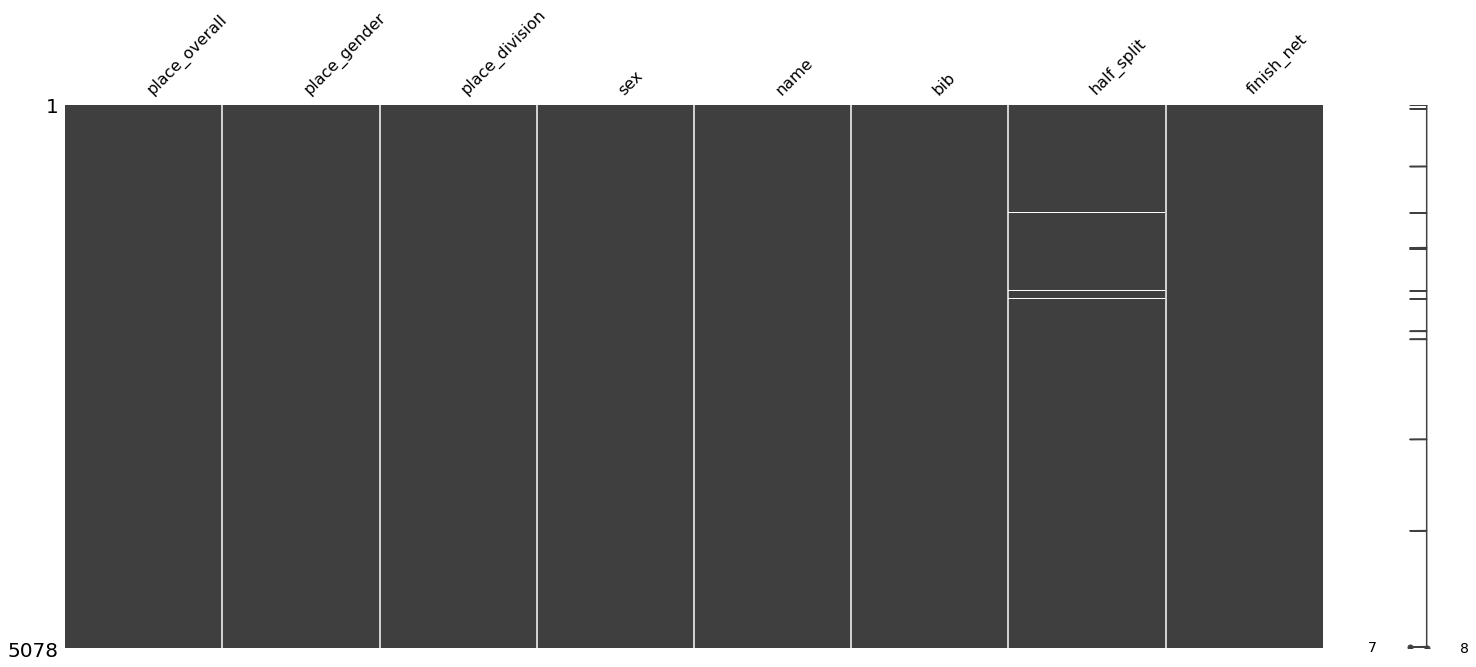

In [14]:
#Sort data by 'place_overall'
sorted_boston = boston.sort_values(by = 'place_overall')

#Show missingness matrices for each data set
msno.matrix(sorted_boston)
plt.show()

Again, the missing values don't appear to follow any pattern. Given the small number of missing values, the lack of discernible patterns in the missingness, and the fact that we really can't use these rows to analyze pace strategy anyway, the best course of action is probably just to drop the rows with missing values.

In [15]:
boston.dropna(subset=['half_split'], inplace = True)

## Check for Duplicate Rows

Let's check for any true duplicate rows in the data (i.e., rows where all the data is exactly the same).

In [16]:
boston_duplicates = boston.duplicated()
boston[boston_duplicates]

,place_overall,place_gender,place_division,sex,name,bib,half_split,finish_net


There are no true duplicate rows, but that doesn't necessarily mean that there is no duplicate data. We know that every runner in a race gets a unique bib number, so there shouldn't be any duplicate bib numbers in the data. Let's check specifically for duplicate bib numbers.

In [17]:
boston_duplicates = boston.duplicated(subset = ['bib'], keep = False)
boston[boston_duplicates]

,place_overall,place_gender,place_division,sex,name,bib,half_split,finish_net


There are no duplicate bib numbers. Let's also check the combination of name and finish time for duplicates. While many runners may have the same name or the same finish time, runners are much less likely to have both.

In [18]:
#Strip white spaces from either end of names
boston['name'] = boston['name'].str.strip()

boston_duplicates = boston.duplicated(subset = ['name', 'finish_net'], keep = False)
boston[boston_duplicates]

,place_overall,place_gender,place_division,sex,name,bib,half_split,finish_net


There are no duplicate combinations of name and finish time either. At this point, we should be fairly satisfied that there are no duplicate rows.

## Column Names

Next, let's clean the column names and make them as clear and consistent as possible. We should change 'place_gender' to 'place_sex', 'half_split' to 'first_half', and 'finish_net' to 'finish'.

In [18]:
#Create dictionary mapping old column names to new column names
columns = {'place_gender':'place_sex', 'bib':'runner_id', 'half_split':'first_half', 
                  'finish_net':'finish'}

#Rename columns using dictionary
boston.rename(columns = columns, inplace = True)

#Check results
boston.columns

Index(['place_overall', 'place_sex', 'place_division', 'sex', 'name',
       'runner_id', 'first_half', 'finish'],
      dtype='object')

## Data Range and Membership Constraints

Now let's check the data for any clearly out-of-range values. First, let's look at some overall descriptive statistics.

In [19]:
boston.describe()

,place_overall,place_sex,place_division,runner_id,first_half,finish
count,5065.000000,5065.000000,5065.000000,5065.000000,5065,5065
mean,6476.462389,3042.122014,1288.035538,9052.897730,0 days 01:44:29.387166831,0 days 03:43:40.235340572
std,4869.775629,2470.085689,763.168335,6672.371511,0 days 00:21:52.742389997,0 days 00:52:24.411769705
min,-2.000000,0.000000,0.000000,2.000000,0 days 01:04:08,0 days 02:09:51
25%,2001.000000,827.000000,636.000000,2373.000000,0 days 01:28:17,0 days 03:04:37
50%,5410.000000,2208.000000,1270.000000,8380.000000,0 days 01:40:06,0 days 03:30:00
75%,10986.000000,5411.000000,1904.000000,16768.000000,0 days 01:56:37,0 days 04:13:13
max,15383.000000,7941.000000,2842.000000,19651.000000,0 days 04:16:22,0 days 07:24:34


The lowest value for "place_overall" is -2. The placing numbers should not be less than 0 (note that we set missing placing numbers to 0 earlier on--those can stay as is). Let's subset the data for these out-of-range values.

In [20]:
#Subset data for any rows with any place number less than 0
boston[(boston['place_overall'] < 0) | (boston['place_sex'] < 0) | (boston['place_division'] < 0)]

,place_overall,place_sex,place_division,sex,name,runner_id,first_half,finish
12215,-2,0,0,W,"Khim, Sary (USA)",19397,0 days 02:59:32,0 days 06:31:17
12225,-2,0,0,W,"Braese, Courtney (USA)",17058,0 days 02:59:48,0 days 06:41:16


These runners are missing placing information, but they otherwise have valid finish time data and half splits. We will treat these as missing values and set them to 0.

In [21]:
#Change values from -2 to 0
boston.loc[boston['place_overall'] < 0, 'place_overall'] = 0

#Check that conversion was successful
assert boston['place_overall'].min() == 0

Next, we know the winning finish times (2:09:51 for men, 2:24:45 for women), so no finish times should be lower than those. The descriptive statistics clearly show that no times are lower than the winning men's times, but it's less obvious if the women's times satisfy this condition, so we can specifically check those with an assert statement.

Split times are a bit harder to validate, but it is probably safe to assume that no one ran a half split faster than the half marathon world record at the time, which was 57:32 for men and 1:04:02 for women. Again, it's obvious from the summary statistics that the men's times satisfy this condition, but we will need to specifically check the women's times.

In [22]:
#Subset the women's times
boston_women = boston[boston['sex'] == 'W']

#Check that women's times are all at least the winning women's time
assert boston_women['finish'].min() >= pd.Timedelta('0 days 2 hours 24 minutes 45 seconds')

#Check that all women's half splits are greater than the world record
assert boston_women['first_half'].min() >= pd.Timedelta('0 days 1 hours 4 minutes 2 seconds')

We also know that all half splits should be less their corresponding finish times, so let's check that as well.

In [23]:
#Print any rows where the half split is greater than the finish time
print(boston[boston['first_half'].gt(boston['finish'])])

Empty DataFrame
Columns: [place_overall, place_sex, place_division, sex, name, runner_id, first_half, finish]
Index: []


It looks like all of our data is within a reasonable range.

## Create New Columns

Let's break the "name" column into three different columns: "first_name", "last_name", and "country". Values in the "name" column appear to follow the pattern of "Last Name, First Name (3-LETTER COUNTRY CODE)", but some of them don't follow this pattern exactly, so we will need to use regular expressions to split these precisely.

In [24]:
def name_split(df):
    """Takes a DataFrame, splits name column into three columns and drops name column."""
    #Split the name column into 'country', 'last_name', and 'first_name'
    df[['name', 'country']] = df['name'].str.split(r'\s\((?=[A-Z]{3})', 1, expand = True)
    df[['last_name', 'first_name']] = df['name'].str.split(', ', 1, expand = True)
    
    #Strip the trailing parenthesis from 'country'
    df['country'] = df['country'].str.strip(')')
    
    #Drop the old 'name' column
    df.drop(['name'], axis = 1, inplace = True)
    
    #Print head to check results
    print(df.head())

name_split(boston)

   place_overall  place_sex  place_division sex  runner_id      first_half  \
1              1          1               1   M          4 0 days 01:06:22   
2              2          2               2   M          3 0 days 01:06:23   
3              3          3               3   M         21 0 days 01:06:21   
4              4          4               4   M         12 0 days 01:06:22   
5              5          5               5   M         22 0 days 01:06:22   

           finish country last_name first_name  
1 0 days 02:09:51     KEN   Kipruto     Benson  
2 0 days 02:10:37     ETH   Berhanu       Lemi  
3 0 days 02:10:38     ETH     Yimer      Jemal  
4 0 days 02:10:47     ETH     Ayana     Tsedat  
5 0 days 02:11:11     KEN  Barsoton    Leonard  


It looks like the function generally created the correct columns as expected, but let's check the unique country codes to see if anything looks incorrect.

In [25]:
print(boston['country'].unique())

['KEN' 'ETH' 'USA' 'NZL' 'CAN' 'ZIM' 'IND' 'IRL' 'COL' 'GUA' 'CHI' 'CRC'
 'TWN' 'MEX' 'BRA' 'RUS' 'JPN' 'SUI' 'CHN' 'ESP' 'GER' 'PER' 'VEN' 'ITA'
 'DOM' 'CPV' 'KOR' 'CZE' 'GBR' 'FRA' 'PLE' 'AUS' 'POL' 'THA' 'UKR' 'ISR'
 'ZAM' 'ARG' 'RSA' 'SWE' 'MYA' 'EGY' 'INA' 'QAT' 'IRI' 'KAZ' 'KUW' 'ALB'
 'SVK' 'PAR' 'HON' 'PAN' 'NED' 'PHI' 'AUT' 'ARU' 'URU' 'ESA' None 'KSA']


The function mostly worked as expected with respect to country codes, but there is a "None" value among the list of unique values. Let's take a closer look at the rows that have a "None" value for country code.

In [26]:
print(boston[boston['country'].isna()])

       place_overall  place_sex  place_division sex  runner_id  \
11747          13148       6161            2354   W      16364   

           first_half          finish country last_name first_name  
11747 0 days 02:07:23 0 days 04:45:07    None     Arato  Georgette  


A quick Google search reveals that this runner is from Massachusetts, so let's fill in her "country" column with "USA".

In [27]:
boston['country'].fillna('USA', inplace=True)

The country codes are hard to read, so let's map these to country names using pycountry.

In [28]:
#Create list of three-letter country codes
list_alpha_3 = [i.alpha_3 for i in list(pycountry.countries)]


def country_convert(df):
    """Takes DataFrame, returns country name if code matches a code in the list, otherwise return 'NA'."""
    #If country code has three letters and is in the list, then return the country name
    if (len(df['country']) == 3 and df['country'] in list_alpha_3):
        return pycountry.countries.get(alpha_3 = df['country']).name
    #Otherwise, return 'NA'
    else:
        return 'NA'

boston['country'] = boston.apply(country_convert, axis = 1)

#Check results
print(boston['country'].unique())

['Kenya' 'Ethiopia' 'United States' 'New Zealand' 'Canada' 'NA' 'India'
 'Ireland' 'Colombia' 'Taiwan, Province of China' 'Mexico' 'Brazil'
 'Russian Federation' 'Japan' 'China' 'Spain' 'Peru'
 'Venezuela, Bolivarian Republic of' 'Italy' 'Dominican Republic'
 'Cabo Verde' 'Korea, Republic of' 'Czechia' 'United Kingdom' 'France'
 'Australia' 'Poland' 'Thailand' 'Ukraine' 'Israel' 'Argentina' 'Sweden'
 'Egypt' 'Qatar' 'Kazakhstan' 'Albania' 'Slovakia' 'Panama' 'Austria']


The country codes may not have mapped cleanly over to country names because there are now fewer country names than country codes. This is probably because pycountry uses ISO 3166 country codes, and the Boston data didn't exactly follow this standard. There isn't much we can do about this besides looking at each country code individually and figuring out it's corresponding country. Since this won't be an essential part of our analysis, we will just use what we have.

Now let's compute some columns that will help us analyze pace strategy. We would like to see the first half, second half, and total finish times expressed as hours, as well as the difference in splits expressed as a percentage of the total finish time, with a negative number indicating a negative split (i.e., a faster second half) and positive number indicating a positive split (i.e., a slower second half).

In [29]:
def compute_split_diff(df):
    """Takes DataFrame with finish and half split times, computes split difference as percentage of finish."""
    
    #Compute second half split time
    df['second_half'] = df['finish'].values - df['first_half'].values
    
    #Compute finish time and first and second half splits in hours
    df['finish_hours'] = df['finish'].values/np.timedelta64(1, 'h')
    df['first_half_hours'] = df['first_half'].values/np.timedelta64(1, 'h')
    df['second_half_hours'] = df['second_half'].values/np.timedelta64(1, 'h')
    
    #Compute split difference as percentage of total finish time
    df['split_diff'] = (df['second_half_hours'].values
                        - df['first_half_hours'].values) * 100 / df['finish_hours'].values

compute_split_diff(boston)

#Check results
boston.head()

,place_overall,place_sex,place_division,sex,runner_id,first_half,finish,country,last_name,first_name,second_half,finish_hours,first_half_hours,second_half_hours,split_diff
1,1,1,1,M,4,0 days 01:06:22,0 days 02:09:51,Kenya,Kipruto,Benson,0 days 01:03:29,2.164167,1.106111,1.058056,-2.220511
2,2,2,2,M,3,0 days 01:06:23,0 days 02:10:37,Ethiopia,Berhanu,Lemi,0 days 01:04:14,2.176944,1.106389,1.070556,-1.646038
3,3,3,3,M,21,0 days 01:06:21,0 days 02:10:38,Ethiopia,Yimer,Jemal,0 days 01:04:17,2.177222,1.105833,1.071389,-1.582036
4,4,4,4,M,12,0 days 01:06:22,0 days 02:10:47,Ethiopia,Ayana,Tsedat,0 days 01:04:25,2.179722,1.106111,1.073611,-1.491016
5,5,5,5,M,22,0 days 01:06:22,0 days 02:11:11,Kenya,Barsoton,Leonard,0 days 01:04:49,2.186389,1.106111,1.080278,-1.181553


Let's create a column that is 1 if a runner ran a Boston Marathon qualifying time and 0 otherwise. Participants in the Boston Marathon who are not running on a charity team must run a qualifying time in another marathon first in order to qualify to run Boston. The Boston Marathon qualifying times vary by age and sex, so the result should be a set of "fast" runners that is relatively independent of age and sex. We can use this later when comparing the pace strategies of "fast" and "slow" runners, rather than using finish time directly. It would be better to look at these groups of BQ and non-BQ runners rather than looking at finish time directly because finish time is likely to be highly correlated with sex, which would introduce multicollinearity into our model.

It is somewhat confusing that we are looking at Boston qualifying times run in the context of the Boston Marathon itself, but we are only interested in these times as a benchmark for a fast marathon.

For runner age 18-34, the qualifying times are 3hrs 00min for men and 3hrs 30min for women. For runners 35-39, the times are 3hrs 05min for men and 3hrs 35min for women. Since we can only see runners 18-39 as one group, let's use the latter set of times as the cutoff.

While we are doing this, let's also drop the old timedelta split and finish time columns because we no longer need them.

In [30]:
#Initialize "bq" column as 0 for both DataFrames
boston['bq'] = 0

#Fill in 1 if runner ran a BQ time
boston.loc[(boston['sex'] == 'M') & (boston['finish'] <= pd.Timedelta('3 hours 5 minutes')), 'bq'] = 1
boston.loc[(boston['sex'] == 'W') & (boston['finish'] <= pd.Timedelta('3 hours 35 minutes')), 'bq'] = 1

#Drop old timedelta split and finish time columns
boston.drop(['first_half', 'second_half', 'finish'], axis = 1, inplace = True)

#Check results
boston

,place_overall,place_sex,place_division,sex,runner_id,country,last_name,first_name,finish_hours,first_half_hours,second_half_hours,split_diff,bq
1,1,1,1,M,4,Kenya,Kipruto,Benson,2.164167,1.106111,1.058056,-2.220511,1
2,2,2,2,M,3,Ethiopia,Berhanu,Lemi,2.176944,1.106389,1.070556,-1.646038,1
3,3,3,3,M,21,Ethiopia,Yimer,Jemal,2.177222,1.105833,1.071389,-1.582036,1
4,4,4,4,M,12,Ethiopia,Ayana,Tsedat,2.179722,1.106111,1.073611,-1.491016,1
5,5,5,5,M,22,Kenya,Barsoton,Leonard,2.186389,1.106111,1.080278,-1.181553,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12235,15372,7435,2838,W,17468,United States,List,Chanit,6.977778,3.129444,3.848333,10.302548,0
12236,15376,7437,2839,W,18401,United States,Marino-Babcock,Emily,7.077778,3.240278,3.837500,8.437991,0
12237,15377,7438,2840,W,17524,United States,Malloy,Meagan,7.108333,3.297500,3.810833,7.221571,0
12238,15379,7440,2841,W,4112,United States,Lee,Sherry,7.163333,3.351111,3.812222,6.437103,0


## Miscellaneous

Let's subset the data for runners who finished faster than five hours. When analyzing pace strategy, we would ideally like to look at only runners who ran the entire race. If a runner walked significant portions of the race but ran other portions, this might inflate thier split difference in a way that wouldn't happen for runners who ran the entire race. We can't pick out these runners exactly, and any cut-off we impose is not going to be perfect. In their study on marathon pace strategy from 2011, March et al. used a cut-off of five hours, and that seems reasonable. This would correspond to an average speed of 5.2 miles per hour over the course of the race, which would be very difficult to walk for any significant period of time.

In [31]:
#Subset runners that did not finish under 5 hours
boston_gt5 = boston[boston['finish_hours'] >= 5].index

#Drop those runners
boston.drop(boston_gt5, axis = 0, inplace = True)

And let's also map the values of the "sex" column from M/F to 1/0, with 1 representing male and 0 representing female. 

In [32]:
boston['sex'] = boston['sex'].map({'M':1, 'W':0})

## Export Clean Data

Now that we have cleaned the data, let's export it to a CSV file.

In [33]:
boston.to_csv('/Users/tmcdermott/Desktop/Data Projects/marathon_splits/data/boston_clean.csv', index=False)